# Analysis of Crowdfunding Projects

### Data Description

Kickstarter.com is a crowd funding website where creators post descriptions of projects they want to create, and individuals contribute some amount of personal money to finance the project. In return for funding, contributors typically get a wide range of “Backer Rewards”. The rewards differ depending on the type of project. For example, a book/video project will typically issue a digital copy of the final product to backers that donate above a given amount. The scope of projects can vary widely, from the initial factory runs of complex hardware products. One creator simply requested ten dollars so he could make some potato salad and instead raised $55,000 and threw a crazy party

### Data Source

Webrobots.io runs a monthly scrape of all Kickstarter projects available on the Kickstarter website. The resulting data are available as both csv and json files, and each package covers a number of projects on the website from the start date (April 21st 2009) until the scrape date. From April 2015, Kickstarter began limiting the number of search results for each category. As a result, the numbers of historical results displayed are limited. Webrobots started running scrapes in multiple sub-categories to capture more instances, and as a result, there are multiple entries for several projects.

### Dates of Study

The scrape data that I'm working with was taken from Kickstarter.com in March of 2019. The scrape data includes both historical and current projects, so there's a wide variety of dates captured here.

# Data issues

### Inconsistent Dates

Kickstarter.com limits the number of search results shown for each category of project (ex. 'Film & Video', or 'Publishing'). Because of this limit and because the number of projects in each category varies based on their relative popularity, the active dates for projects across different categories are not all the same. As we'll see later, the popularity of the Kickstarter.com website fluctuates over time, so different launch dates can affect a project's chances of success

### Missing, incorrect or duplicate data

The overall quality of the dataset is very good, with very few pieces of missing data.

# Scope and Goals

### Audience and Business Need

This project is aimed at creators that are interested launching projects on Kickstarter's platform. Kickstarter campaigns are "all or nothing", meaning if a campaign doesn't reach the funding goal, all of the funds are returned to backers. For this reason, it's important for campaigns to carefully consider how their project is presented

### Previous Work 

There's been a lot of work published using Kickstarter datasets in the past. Most of the past work has focused on trying to predict whether a project will achieve their funding goal based on characteristics such as funding goal, project  category, and number of backers. While that's interesting from a technical/model optimization view, actionable information for creators is limited so far. 

Citations for previous work is given in Appendix B at the end of this notebook

### Project Goal

In light of the previous work done and the popularity of the dataset, this project attempts to approach this dataset from an original angle. The main question I'm trying to answer here is:

* *Can we create a way for new creators to make their campaigns "look" like successful projects* 

This project aims to achieve that by running a segmentation analysis on attributes of successful and unsuccesful projects and try to uncover their differences



# Data Cleaning and Manipulation

### JSON Formatting

Many of columns in the original dataset were returned as JSON objects during the webrobots scrape. When exporting to a .csv file, and then importing into Pandas, the JSON formatting was lost. The cleaning script made for this project re-applied the JSON formatting, and then pulled the relevant information back out

### Interpreted Data
Some columns were made with interpreted data. Time deltas were calculated between:
* Campaign launch date and campaign creation date
* Campaign launch date and campaign deadline
* Campaign launch date and date funding goal was reached

Natural Language Processing was run on project titles and descriptions to better define project differences. The data from the NLP analysis was used to score project descriptions on their active phrasing and whatever other criteria I make up 

### Pruning and other cleaning
The remaining cleaning work has been selecting the data relevant to the project. The original dataset contained contained image url's, and duplicates of data available in other columns. These items were removed from the dataset used for analysis

### Date formats 

All of the columns that are time/date related are in epoch time, and I've left it that way to make things easier to do math

### External Data

Data pulled from IndieGoGo has been merged in with the Kickstarter dataset for comparison

In [60]:
#Import libraries needed for analysis
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pdb
import time
import re
import math as mt
url = 'https://tufts.box.com/shared/static/939cuad4z6ieo8njf3ya58a603q4enyh.csv'
df = pd.read_csv(url, index_col = 0)
len(df)

208240

### Project states

There are four different states listed for each project in the dataset:

| State | Description|
|:---:|:---:|
|Live | Project is currently actively fundraising|
|Cancelled | Project was cancelled by the creators before the deadline | 
|Suspended | The project was suspended by Kickstarter for not meeting some criteria|
|Succesful| The project has met or exceeded the funding goal |
|Failed| The project failed to meet their funding goal| 

Since this project aims to analyze factors that make projects successful, I've filtered the dataset to include only projects that are either successful or failed

# Merge in External Data

Webrobots.io also runs a monthly scrape of the indiegogo website. Since there's already been a large amount of work done on Kickstarter data in the past, I want to try and make some unique analyses using a new dataset.

I grabbed the most recent version of the indiegogo dataset, and now I'm going to merge it with my Kickstarter dataset

In [69]:
#Start by taking a look at the indiegogo dataset
url = 'https://tufts.box.com/shared/static/on2cmdxc4vqpm2dutaaf7l8764ktq0u5.csv'
indie = pd.read_csv('https://tufts.box.com/shared/static/on2cmdxc4vqpm2dutaaf7l8764ktq0u5.csv')
#Drop columns that are unrelatd to the original kickstarter dataset
indie.drop(labels = ['bullet_point', 'category_url', 'clickthrough_url', 'image_url', 'is_pre_launch', 'offered_by', 
                     'price_offered', 'product_id', 'product_stage', 'project_type', 'price_retail', 
                     'perk_goal_percentage', 'tags'], axis = 1, inplace = True)

In [70]:
indie.head()

,category,close_date,currency,funds_raised_amount,funds_raised_percent,is_indemand,open_date,perks_claimed,project_id,source_url,tagline,title
0,Home,2018-07-16T23:59:59-07:00,GBP,10694.0,1.065059,True,2018-07-15T23:59:59-07:00,58.0,2397370,https://www.indiegogo.com/explore/all?project_...,Make a brew for two with one press using the A...,2POUR An Accessory For Aeropress Coffee Maker
1,Web Series & TV Shows,2017-09-12T23:59:59-07:00,AUD,30.0,0.003000,False,2017-07-14T06:19:44-07:00,0.0,2152925,https://www.indiegogo.com/explore/all?project_...,This street is the stage where the theatre mee...,Hustle Street - A musical
2,Photography,2013-02-13T23:59:59-08:00,USD,7060.0,0.415294,False,2012-12-10T09:05:14-08:00,65.0,291347,https://www.indiegogo.com/explore/all?project_...,Creating a photo-narrative book that captures ...,The Thru-Project
3,Home,2017-01-07T23:59:59-08:00,EUR,20.0,0.000020,False,2016-11-24T01:51:38-08:00,2.0,1951140,https://www.indiegogo.com/explore/all?project_...,World 1st Charity Contest of religious communi...,Way2goodness
4,Health & Fitness,2018-07-11T23:59:59-07:00,USD,250036.0,6.750033,True,2018-07-10T23:59:59-07:00,532.0,2393782,https://www.indiegogo.com/explore/all?project_...,Wake up gently every morning by stimulating th...,Sensorwake Trio: The scent-based alarm clock


# Making the Indiegogo data look like the Kickstarter data

Since the two websites are unique, there's a lot of differences in how the datasets are structured

The following few steps are manipulating the indiegogo data to look like the Kickstarter data

### Date Conversion

First up, change the dates that are in a YY/MM/DD format and conver tat into epoch time (the standard for the Kickstarter dataset)

In [71]:
import datetime # Library for working with datetime information
indie.dropna(inplace = True) # Drop rows that are missing important information
def epoch(target): 
    '''
    This function takes a date from the indiegogo dataset (read originally as a string), converts to a datetime object
    and then converts that date to epoch time
    '''
    target = target.split('T')
    target = datetime.datetime.strptime(target[0], '%Y-%m-%d')
    target = target.strftime('%s')
    return(target)
#Run the epoch function on the project close date and project open date columns
indie.close_date = indie.close_date.apply(epoch) 
indie.open_date = indie.open_date.apply(epoch)

### Renaming Categories

The category labels for indiegogo don't quite match up to Kickstarter categories. I've made a dictionary to convert the indiegogo categories to match Kickstarter categories

In [72]:
indieDictionary = { 'Home' : 'crafts',
                   'Web Series & TV Shows' : 'film & video',
                   'Photography' : 'photography',
                   'Health & Fitness' : 'health & fitness',
                   'Comics' : 'comics',
                   'Food & Beverages' : 'food',
                   'Music' : 'music',
                   'Dance & Theater' : 'dance',
                   'Podcasts, Blogs & Vlogs' : 'journalism' ,
                   'Video Games' : 'games',
                   'Art' : 'art',
                   'Fashion & Wearables' : 'fashion',
                   'Phones & Accessories' : 'technology',
                   'Wellness' : 'health & fitness',
                   'Camera Gear': 'camera gear',
                   'Travel & Outdoors': 'travel & outdoors',
                   'Film' : 'film & video',
                   'Productivity': 'productivity',
                   'Tabletop Games':  'games',
                   'Audio' : 'music',
                   'Culture' : 'culture',
                   'Human Rights' : 'human rights',
                   'Environment' : 'environment',
                   'Writing & Publishing' :  'publishing',
                   'Transportation' : 'technology',
                   'Local Businesses' : 'local businesses',
                   'Energy & Green Tech' : 'energy & green tech'}

### Column Names, Epoch Time Conversion, and some Math

Rename the columns of the indiegogo data to match the kickstarter column names. When the dates were converted to epoch time in the step above, the data was read as a string type. Convert those to ints

Finally, calculate how long the fundraising campaigns were for each project

In [73]:
indie.category = indie.category.map(indieDictionary) # Use the dictionary to re-categorize the indiegogo projects
indie['source'] = 'indiegogo' # Add an indiegogo tag column to separate kickstarter and indiegogo data
indie = indie.rename(index=str, columns={"close_date": "deadline", # Rename each column header to match kickstarter
                              "funds_raised_amount": "usd_pledged", 
                              "open_date" : "launched_at",
                              "is_indemand":"spotlight", 
                              "tagline" : "blurb", 
                              "title":"name", 
                              "perks_claimed" : "backers_count",
                              "project_id": "id", 
                              "category" : "fullcats",
                              "source_url" : "urls"})
indie.deadline = indie.deadline.astype(int) 
indie.launched_at = indie.launched_at.astype(int)
#Calculate how long each fundraising campaign was run for
indie['lauDeadDelta'] = indie.apply(lambda x: (x["deadline"] - x["launched_at"])/60/60/24, axis = 1)
indie['goal'] = indie.apply(lambda x: (mt.ceil(x['usd_pledged'] / (x['funds_raised_percent'] + 0.00000000001))), axis = 1)
indie['funds_raised_percent'] = indie.apply(lambda x: (x['funds_raised_percent'] * 100), axis = 1)
indie['state'] = 'finished'

### Merge the two DataFrames together

Now that the two datasets look alike, merge them together with an outer join (include only entries that in either dataset, but not both)

In [74]:
merged = df.merge(indie, how = 'outer', on = None)
merged.reset_index(inplace = True)
merged.drop(labels = 'index', axis = 1, inplace = True)
merged

/Users/chrismay/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:938: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
/Users/chrismay/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:946: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


,backers_count,blurb,country,created_at,creator,currency,deadline,fx_rate,goal,id,...,urls,usd_pledged,subcats,fullcats,city,creLauDelta,lauDeadDelta,staLauDelta,source,funds_raised_percent
0,9,A comedy web series about the inherently funny...,US,1.489891e+09,9.154303e+08,USD,1494132705,1.000000,5000.0,1203770415,...,https://www.kickstarter.com/projects/915430313...,508.000000,Comedy,film & video,"Austin, TX",19.0,30.000000,30.0,Kickstarter,10.160000
1,36,"Cabo y un Capitán, dos soldados villistas, tra...",MX,1.508480e+09,1.011929e+09,MXN,1512917074,0.052034,65000.0,878861613,...,https://www.kickstarter.com/projects/101192872...,3397.485019,Shorts,film & video,"Mexico City, Mexico",16.0,35.000000,35.0,Kickstarter,5.226900
2,61,We're building the new home of Māori Theatre a...,NZ,1.426500e+09,1.902194e+09,NZD,1429596000,0.685030,10000.0,917345297,...,https://www.kickstarter.com/projects/190219404...,7834.340234,Theater,theater,"Auckland, NZ",7.0,28.000000,28.0,Kickstarter,78.343402
3,1730,Comic-book stories celebrate women who crack c...,US,1.482813e+09,1.211241e+08,USD,1489666144,1.000000,40000.0,1702164653,...,https://www.kickstarter.com/projects/hificolou...,97447.000000,Anthologies,comics,"Scottsdale, AZ",49.0,29.000000,29.0,Kickstarter,243.617500
4,183,"A Victorian “gaslamp” lesbian romance, set in ...",US,1.506229e+09,4.846543e+08,USD,1510473540,1.000000,2000.0,1042930184,...,https://www.kickstarter.com/projects/484654302...,3911.000000,Video Games,games,"San Francisco, CA",16.0,32.000000,32.0,Kickstarter,195.550000
5,35,Faded Days | Sunglasses designed for people wi...,US,1.541727e+09,1.340888e+09,USD,1550948381,7.848275,5000.0,1985172371,...,https://api.kickstarter.com/v1/projects/198517...,4528.000000,Product Design,design,"Charlotte, NC",76.0,30.000000,0.0,Kickstarter,90.560000
6,234,The most powerful adapter and charging battery.,US,1.501644e+09,6.217901e+08,USD,1508030899,1.000000,5000.0,1512922931,...,https://www.kickstarter.com/projects/621790149...,17003.000000,Hardware,technology,"USA, AL",13.0,60.000000,60.0,Kickstarter,340.060000
7,234,The most powerful adapter and charging battery.,US,1.501644e+09,6.217901e+08,USD,1508030899,1.000000,5000.0,1512922931,...,https://www.kickstarter.com/projects/621790149...,17003.000000,Hardware,technology,"USA, AL",13.0,60.000000,60.0,Kickstarter,340.060000
8,0,It is time for Frank to get his due. It is tim...,US,1.418498e+09,6.719973e+08,USD,1419227940,1.000000,20.0,1550408907,...,https://www.kickstarter.com/projects/671997308...,0.000000,Comedy,film & video,"Loxley, AL",2.0,6.000000,6.0,Kickstarter,0.000000
9,239,A whimsical and super cute galaxy narwhal char...,US,1.510765e+09,1.964538e+08,USD,1522944476,1.000000,4750.0,280120180,...,https://www.kickstarter.com/projects/inki-drop...,12328.000000,Crafts,crafts,"Sacramento, CA",106.0,34.000000,34.0,Kickstarter,259.536842


### Convert Foreign Currencies to USD terms

There's a large number of projects that originated outside of the US. For these projects, the funding goals are in a different currency. In order to clean up the dataframe for analysis, convert these into USD terms.

Kickstarter.com was kind enough to include the prevailing currency exchange rate at the time of the project, so I'll use that for the conversion

In [75]:
# Multiply the goal by the fx rate, then recalculate the % of goal pledged
merged['goal'] = merged.apply(lambda x: (x['goal'] * x['fx_rate']), axis = 1) 
merged['funds_raised_percent'] = merged.apply(lambda x: (x['usd_pledged'] / x['goal'])*100, axis = 1)

# Exploratory Data Analysis

### Differences by Project Category

Start analyzing the data from the two datasets by taking a look at how success rates and funding goals differ across each category

In [76]:
#Filter out projects that are live, canceled, or suspended
fil = merged[(merged['state'] == 'successful')|(merged['state'] =='failed') | (merged['state'] == 'finished')] 
sucMask = (fil['state'] == ('successful')) | (fil['state'] == ('finished'))
suc = fil[sucMask]
fSuc = len(suc)/len(fil)
print('The relative frequency of projects meeting their funding goal is', fSuc, 'or about', mt.floor(fSuc * 100), '%')
print('note: Indiegogo projects receive funding regardless of amounts of money pledge')

The relative frequency of projects meeting their funding goal is 0.6464342760499859 or about 64 %
note: Indiegogo projects receive funding regardless of amounts of money pledge


# Analyzing project success

Now we know that abotu 64% of all projects receive funding at the end of their campaign

Let's take a closer look at which projects raise the most money, and how that slit happens across categories

In [77]:
merged.describe()

,backers_count,created_at,creator,deadline,fx_rate,goal,id,launched_at,state_changed_at,usd_pledged,creLauDelta,lauDeadDelta,staLauDelta,funds_raised_percent
count,228497.000000,2.082400e+05,2.082400e+05,2.284970e+05,208240.000000,2.082400e+05,2.284970e+05,2.284970e+05,2.082400e+05,2.284970e+05,208240.000000,228497.000000,208240.000000,2.082400e+05
mean,151.091769,1.454714e+09,1.074468e+09,1.462499e+09,1.001831,4.039583e+04,9.779521e+08,1.459612e+09,1.461459e+09,1.577561e+04,47.002382,33.220522,30.371264,4.904703e+02
std,936.941377,6.233873e+07,6.202857e+08,6.248032e+07,0.335579,1.093849e+06,6.653684e+08,6.252293e+07,6.184290e+07,1.178134e+05,130.548895,13.442486,13.234609,2.457838e+04
min,0.000000,1.240366e+09,3.000000e+00,1.242468e+09,0.009007,1.000000e-02,3.271000e+03,1.240920e+09,1.242468e+09,0.000000e+00,0.000000,-1.000000,0.000000,0.000000e+00
25%,3.000000,1.412760e+09,5.371463e+08,1.419552e+09,1.000000,1.500000e+03,3.769857e+08,1.416522e+09,1.419869e+09,1.250000e+02,2.000000,29.000000,28.000000,2.324000e+00
50%,25.000000,1.456788e+09,1.073502e+09,1.464926e+09,1.000000,5.000000e+03,9.727366e+08,1.462193e+09,1.463505e+09,1.525000e+03,11.000000,30.000000,30.000000,1.022500e+02
75%,86.000000,1.509249e+09,1.612665e+09,1.518412e+09,1.000000,1.290333e+04,1.556499e+09,1.515647e+09,1.516385e+09,6.622000e+03,36.000000,36.000000,32.000000,1.290000e+02
max,105857.000000,1.550094e+09,2.147483e+09,1.555301e+09,10.126885,1.290333e+08,2.147476e+09,1.550207e+09,1.550119e+09,1.571227e+07,3303.000000,966.958333,93.000000,6.876410e+06


# Data Skew

From a first look at the descriptive statistics on the dataset, the data seems to be heavily skewed.

The means and medians (50%) for "goal", and "usd_pledged", are off by an order of magnitude.

I know there's a lot of different categories of projects, and some of the skew is probably due to different funding goals for different categories of projects (ex. A video publishing project needs a lot less money than the first run of a new hardware device)

Knowing some of the skew comes from differences in project categories, let's take a closer look grouping by project category

# Comparing the Money Raised
The chart below compares average money pledged to projects in different categories against average raised in succesfully funded projects. It also gives a comparison of the medians for each category

As was seen in the descriptive statistics, there's a heavy skew here. Based on the median pledge totals, it seems like a lot of projects must raise almost no money at all

<Figure size 43200x21600 with 0 Axes>

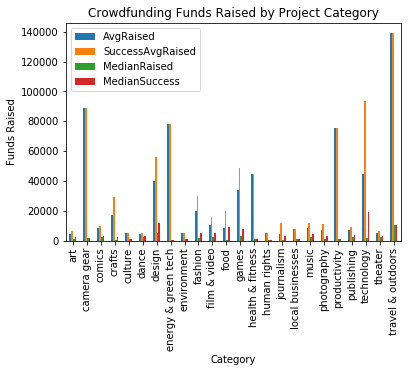

<Figure size 43200x21600 with 0 Axes>

In [78]:
# Compare the money raised by succesfull projects against all projects in a certain category
money = pd.DataFrame()
grp = fil.groupby(['fullcats'])
sucGrp = suc.groupby(['fullcats'])
money['AvgRaised'] = grp.usd_pledged.agg(np.mean)
money['SuccessAvgRaised'] = sucGrp.usd_pledged.agg(np.mean)
money['MedianRaised'] = grp.usd_pledged.agg(np.median)
money['MedianSuccess'] = sucGrp.usd_pledged.agg(np.median)
#money.reset_index(inplace = True)

ax = money.plot(kind = 'bar', title='Crowdfunding Funds Raised by Project Category')
ax.set_xlabel("Category")
ax.set_ylabel("Funds Raised")
plt.figure(figsize=(600,300))


# Comparing pledge goals

The same skew shows up in the fundraising goals for each project, there seems to be a few projects that have very high funding goals.

What's interesting here is that most projects have significantly lower funding goals than the top projects. It's difficult to see, but it also seems there's a relatively small difference in the median funding goals between successful projects and all projects

<Figure size 43200x21600 with 0 Axes>

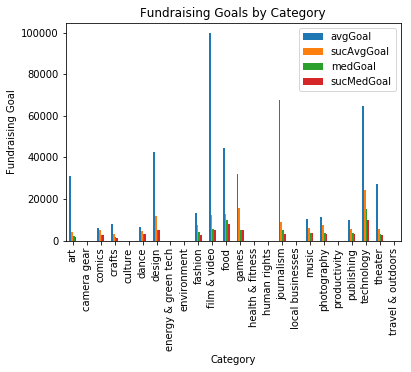

<Figure size 43200x21600 with 0 Axes>

In [79]:
# Compare the funding goals for successful projects in each category vs. the funding goals of all projects
goal = pd.DataFrame()
goal['avgGoal'] = grp.goal.agg(np.mean)
goal['sucAvgGoal'] = sucGrp.goal.agg(np.mean)
goal['medGoal'] = grp.goal.agg(np.median)
goal['sucMedGoal'] = sucGrp.goal.agg(np.median)

ax = goal.plot(kind = 'bar', title='Fundraising Goals by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Fundraising Goal")
plt.figure(figsize=(600,300))

## Backers information

No surprises that succesfully funded projects have more backers than the general population

The average number of backers for each category seems to give more evidence to a few very popular projects skewing the average

Since this is just a count of total number of backers, and not the amounts they pledged, the top projects not only raise much larger amounts of money, but they also get a very large number of small donors as well

<Figure size 43200x21600 with 0 Axes>

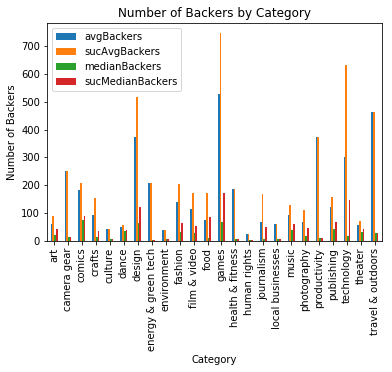

<Figure size 43200x21600 with 0 Axes>

In [80]:
# Look at the number of backers for successful projects in each category vs. the backers for all projects
backers = pd.DataFrame()
backers['avgBackers'] = grp.backers_count.mean()
backers['sucAvgBackers'] = sucGrp.backers_count.mean()
backers['medianBackers'] = grp.backers_count.median()
backers['sucMedianBackers'] = sucGrp.backers_count.median()
#backers.reset_index(inplace = True)
ax = backers.plot(kind = 'bar', title='Number of Backers by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Number of Backers")
plt.figure(figsize=(600,300))

## Funding success across categories

The most popular categories generally have the lowest success rates, while things like comics, design photography, and games seem to perform better than average.

These categories would likely typically have fanbases that closely follow the creators. Due to this, they have a reliable audience to draw from when try to source funds for their campaigns

<Figure size 43200x21600 with 0 Axes>

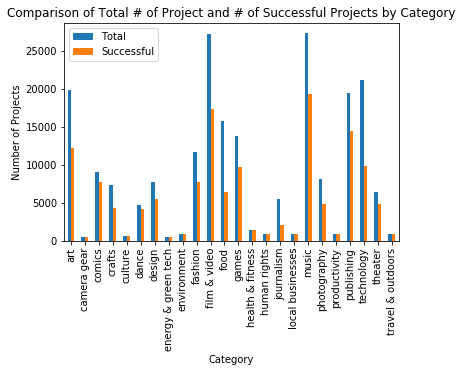

<Figure size 43200x21600 with 0 Axes>

In [81]:
# Look at the number of successfully funded projects in each category vs. the total number of projects
counts = pd.DataFrame()
counts['Total'] = grp.size()
counts['Successful'] = sucGrp.size()
#counts.reset_index(inplace = True)
ax = counts.plot(kind = 'bar', title='Comparison of Total # of Project and # of Successful Projects by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Number of Projects")
plt.figure(figsize=(600,300))

## Success rate of projects above a certain amount raised

Because of the large differences between the average funds raised and the median funds raised, it seems like there would be a large number of projects that raise hardly any money at all. 

Let's take a closer look project success rate versus the amount of money raised

Text(0.5, 1.0, 'Funding Goals and Success Rates')

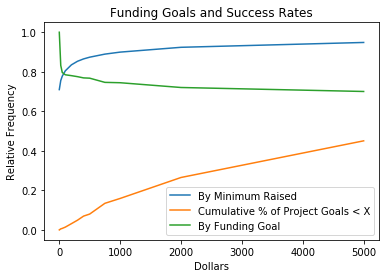

In [82]:
minRaised = [1, 25, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 5000]
lowGoals = [1, 25, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 5000]
succRate = []
goalRate = []
lowGoalSuccess = []
for raised in range(len(minRaised)):
    gotMoney = fil[fil['usd_pledged'] > minRaised[raised]]
    gotMoneySuccess = gotMoney[(gotMoney['state'] == 'successful') | (gotMoney['state'] == 'finished')]
    tempRate = len(gotMoneySuccess) / len(gotMoney)
    succRate.append(tempRate)

for goals in range(len(lowGoals)):
    goalFilter = fil[fil['goal'] < lowGoals[goals]]
    lowSuccess = goalFilter[(goalFilter['state'] == 'successful') | (goalFilter['state'] == 'finished')]
    tempGoals = len(goalFilter) / len(fil)
    tempLowSuccess = len(lowSuccess) / len(goalFilter)
    goalRate.append(tempGoals)
    lowGoalSuccess.append(tempLowSuccess)
    
graph = pd.DataFrame({'Dollars' : minRaised,
                     'Minimum_Raised' : succRate,
                     '%_of_Projects' : goalRate,
                     'Success_by_Goal' : lowGoalSuccess})
x = graph['Dollars']
y1 = graph['Minimum_Raised']
y2 = graph['%_of_Projects']
y3 = graph['Success_by_Goal']

plt.plot(x, y1, x, y2, x, y3)
plt.legend(('By Minimum Raised', 'Cumulative % of Project Goals < X', 'By Funding Goal'),
           loc='lower right')
plt.xlabel('Dollars')
plt.ylabel('Relative Frequency')
plt.title('Funding Goals and Success Rates')

## Funding Goals, Minimum Amount Raised, and Success Rates

In the plot above:
'By Minimum Raised' Shows relative frequency of success in projects that raised at least the amounts on the x axis

'Cumulative % of Project Goals' shows the % of projects that have funding goals less than the amounts on the x axis

'By Funding Goal' shows relative frequency of successful projects that have goals lower than amounts on the x axis

While a small % of projects have funding goals less than $1,000, projects that raised up to that amount have an outsized chance of meeting their funding goal. 

This idea seems to stress the importance of finding ambitious "first movers" from the general public to pledge support to projects and share with their friends. This supports the idea that project categories which have fanbases that closely follow project creators have a much better chance at reaching their funding goals. 

Let's take a closer look at the number of backers

# Number of Backers and Success Rate

The plot below shows the success rate of projects where the number of backers exceeds the number on the x axis

This seems to confirm that finding a small number of individual backers to support the project at the start greatly increases the chances of a project reaching its funding goal  

Text(0.5, 1.0, 'Success Rate vs. # of Backers')

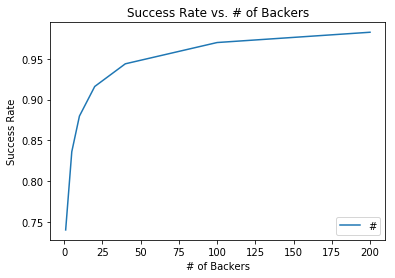

In [83]:
backers = [1, 5, 10, 20, 40, 100, 200]
succRate = []
for backer in range(len(backers)):
    backed = fil[fil['backers_count'] > backers[backer]]
    backedSuccess = backed[(backed['state'] == 'successful') | (backed['state'] == 'finished')]
    tempRate = len(backedSuccess) / len(backed)
    succRate.append(tempRate)
    
graph = pd.DataFrame({'Success_Rate' : succRate,
                     '#_of_Backers' : backers})
    
x = graph['#_of_Backers']
y1 = graph['Success_Rate']

plt.plot(x, y1)
plt.legend(('# of Backers'),loc='lower right')

plt.xlabel('# of Backers')
plt.ylabel('Success Rate')
plt.title('Success Rate vs. # of Backers')

### Time between Project Creation and Project Launch

Kickstarter allows creators to create a landing page for their projects before the project is officially launched. This time is for creators to raise awareness about the funding campaign, field questions from potential donors and tweak the campaign before making it live

There's a clear relationship showing that a delay of between 20 and 30 days gives the most benefit 

Text(0.5, 1.0, 'Cumulative Success Rates vs. Number of Days between Project Launch and Project Creation')

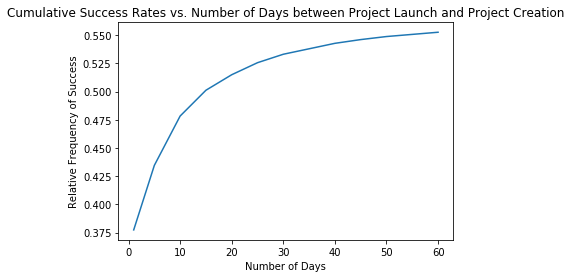

In [84]:
# Plot the delta between launch and creation date vs. success rate
# Plot the campaign length against success rate
launchCreate = [1, 5, 10, 15, 20, 25, 30, 40, 45, 50, 60]
launchSuccess = []
copy = merged.copy()
for i in range(len(launchCreate)):
    longTemp = copy[(copy['creLauDelta'] < launchCreate[i])]
    longTempSuccess = longTemp[(longTemp['state'] == 'successful') | (longTemp['state'] == 'finished')]
    if len(longTemp) == 0:
        tempRate = 0
    else:
        tempRate = len(longTempSuccess) / len(longTemp)
    launchSuccess.append(tempRate)

graph = pd.DataFrame({'creLauDelta' : launchCreate,
                     'Success_by_Delta' : launchSuccess})
x = graph['creLauDelta']
y1 = graph['Success_by_Delta']

plt.plot(x, y1)
plt.xlabel('Number of Days')
plt.ylabel('Relative Frequency of Success')
plt.title('Cumulative Success Rates vs. Number of Days between Project Launch and Project Creation')

# Remaining EDA

### Examining Project Presentation using NLP

This is what the Kickstarter.com homepage looks like

Projects shown on the homepage have just an image, a title, and one sentence of text to lure folks into checking out their project

My next step is to try using the NLP library Spacy to run a semantics analysis on these one sentence blurbs. The goal there is to try and tag different parts of speech used in the blurb and see if there's any relationship between the speech used and project fundraising performance

![alt text](https://i.imgur.com/pny8CS7.png)



### Fundraising rate and total project performance

In the dataset that I have, I know how quickly projects reached their funding goal. An interesting point in the next stage of my analysis is to take a look at whether quickly reaching the funding goal leads to a major increase in total pledged funding.

### Alexa Site Ranking and Traffic Data

I was able to pull Alexa ranking data for both Kickstarter.com and Indiegogo. I'm going to merge this into the existing dataset and check if there's a correlation between page rank and rate of success for all projects during a given time frame.

The idea here is that more people visiting the site would bring an increase in projects being funded. 

### Modeling and Final Project Goals

The final goal here is for me to use unsupervised learning to try and run a segmentation analysis on high performing projects, given the information in this current dataset.

The target is to create guidelines for potential creators to use to tailor their Kickstarter campaigns to look more like highly performing projects. 

# Appendix A: Data Descriptions

| Columns | Data Type | Description | 
|---|---|---|
|Backers Count| int64 | Total number of individual backers of a project
|Blurb|object| The short description of the project
|Category| list | A list of categories that the project has been tagged under
|Country| string| Two character country code of the campaign’s headquarters
|Created_at|int64| The creation date of the campaign in epoch time
|Creator| string |A list of the creator’s name and their creator ID on Kickstarter.com
|Currency| string| A two character string of the domestic currency of the project
|Deadline| int64|The end date/time of the campaign in epoch time
|Goal| int64|The funding goal of the project in native currency
|Id| int64|The unique project ID
|Launched_at| int64|Launch date of the campaign in epoch time
|Location| string|The main location of the project
|Name| object|The name of the project
|Pledged| int64|Total amount pledged (in the project’s home currency)
|Slug| string|An abbreviated description of the project
|Spotlight|string|True/False categorical variable of whether the project was featured by Kickstarter
|Staff_pick|string|True/False categorical variable of whether the project was a staff pick or not
|State|string|Successful/Failed/Canceled/Active  categorical variable of the projects current status
|State_changed_at| int64|Time/date that the project changed states, in epoch time
|Static_usd_rate| int64|Static conversion rate between home currency and USD
|Urls| string|Various URL’s associated with the project
|Usd_pledged| int64|Total amount pledged, converted to USD


# Appendix B: Previous Work and Citations

[Good Audience](https://blog.goodaudience.com/kickstarter-projects-prediction-of-state-steps-for-a-beginner-analysis-f4630a50b7fe)<br>
•	Runs logistic regression, XGBoost, Random forests, LightGBM and an Ensemble method to try and predict whether a project will be successfully funded or not. Based on the Kaggle dataset (limited to 49k entries). Mainly focused on feature selection

[Towards Data Science](https://towardsdatascience.com/predicting-the-success-of-kickstarter-campaigns-3f4a976419b9)<br>
•	Again predictions on successful funding, based on funding goals, category, rewards levels, and location data. Uses random forests, logistic regression, and kNearest Neighbors

[Bentley University](https://www.bentley.edu/prepared/what-secret-perfect-kickstarter-campaign)<br>
•	Finds length of description and title are important
•	Also the date of the launch important (winter is the best month)
•	Higher average donations, shorter campaign durations
